# MiniTAP: MCP Toolbox を活用した Agentic Data Analytics 入門

## 📊 ハンズオン概要

この Notebook は、**MCP (Model Context Protocol) Toolbox for Databases** を活用して、Google Trends データの高度な分析を行うハンズオン学習環境です。

ローカルと Agent Engine の両方で MCP Toolbox を活用し、AI エージェントによるデータ分析の最新手法を体験できます。

## 🎯 ハンズオンのゴール

**「MCP を活用したエージェントによるデータアナリティクスの基本レベル体験」**

- **MCP アーキテクチャ**の理解と実践的活用
- **MCP Toolbox for Databases** による設定ベースのツール管理
- **Cloud Run** でのスケーラブルなMCPサーバーデプロイ
- **ADK + Agent Engine** での本格的なエージェント開発・運用

## はじめに - AI によるデータ分析の夜明け

膨大なデータが眠る BigQuery を前に、『このデータから、自然言語で対話するようにインサイトを引き出せないだろうか』と考えたことはありませんか？

本ハンズオンでは、Google Cloud の ADK (Agent Development Kit) を使い、それを実現する AI エージェントを構築します。

構築にあたり、**(A) ADK の標準機能で迅速に開発するパターン**と、**(B) MCP Toolbox を使い、より高度なガバナンスと拡張性を実現するパターン** の 2 つのアプローチを体験します。それぞれの違いを学び、ビジネス要件に最適なアーキテクチャを選定できるスキルを身につけましょう。

![image](https://raw.githubusercontent.com/googleapis/genai-toolbox/main/docs/en/getting-started/introduction/architecture.png)

---

## 第 1 章：環境構築

### 📋 **事前準備**

#### ライブラリのインストール

In [1]:
# === ライブラリのインストール ===

!pip install toolbox-core==0.5.0 -q
!pip install google-cloud-aiplatform==1.110.0 -q
!pip install google-adk==1.13.0 -q
!pip install google-genai==1.30.0 -q
!pip install google-cloud-bigquery==3.36.0 -q
!pip install requests==2.32.5 -q
!pip install python-dotenv==1.1.1 -q
!pip install db-dtypes==1.4.3 -q
!pip install nest-asyncio==1.6.0 -q

print("✅ ライブラリのインストールが完了しました。")

✅ ライブラリのインストールが完了しました。


### Google Cloud への認証

まず、この Notebook 環境からあなたの Google Cloud プロジェクトを操作できるよう、認証を行います。

以下のコマンドを実行すると認証用のリンクが表示されるので、クリックしてログインしてください。

In [ ]:
gcloud auth application-default login

#### 自動プロジェクトセットアップ

下記のコマンドを**ターミナル**で実行してください。

In [ ]:
# プロジェクト ID の自動検出と設定
python setup/setup_project.py

# BigQuery 環境の準備
python setup/bigquery_setup.py

#### プロジェクト設定

必要な変数を取得し、定義します。

In [3]:
import os
import subprocess
import vertexai
from google.cloud import bigquery
import requests
import json
from datetime import datetime, timedelta
from typing import List, Dict, Any
import warnings
from toolbox_core import ToolboxClient
from dotenv import load_dotenv
import nest_asyncio
import asyncio
warnings.filterwarnings('ignore')

nest_asyncio.apply()
load_dotenv()
# プロジェクト設定
GOOGLE_CLOUD_PROJECT = os.environ.get("GOOGLE_CLOUD_PROJECT")

if not GOOGLE_CLOUD_PROJECT:
    print("❌ プロジェクト ID が検出できませんでした")
    print("💡 gcloud config set project YOUR_PROJECT_ID を実行してください")
    GOOGLE_CLOUD_PROJECT = input("プロジェクト ID を手動で入力してください: ")

# 自動バケット名生成（プロジェクト ID ベース）
STAGING_BUCKET = f"gs://{GOOGLE_CLOUD_PROJECT}-linyuting"
LOCATION = "us-central1"

print(f"📕 使用するプロジェクト: {GOOGLE_CLOUD_PROJECT}")
print(f"📦 使用するバケット: {STAGING_BUCKET}")

# 環境変数設定
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "True"
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION

# Vertex AI 初期化
vertexai.init(
    project=GOOGLE_CLOUD_PROJECT,
    location=LOCATION,
    staging_bucket=STAGING_BUCKET,
)

# モデル定数を定義
DEFAULT_MODEL = "gemini-2.5-pro"
LITE_MODEL = "gemini-2.5-flash"

# ログ設定（不要な警告を非表示）
import logging
class _NoFunctionCallWarning(logging.Filter):
    def filter(self, record: logging.LogRecord) -> bool:
        message = record.getMessage()
        if "there are non-text parts in the response:" in message:
            return False
        else:
            return True

logging.getLogger("google_genai.types").addFilter(_NoFunctionCallWarning())

print("✅ 環境セットアップ完了")

📕 使用するプロジェクト: data-agent-bq
📦 使用するバケット: gs://data-agent-bq-linyuting
✅ 環境セットアップ完了


### データソースの準備 - BigQuery 接続と Google Trends データ

##### 📊 使用するデータセットの概要

**Google Trends - International BigQuery Public Dataset**
- Dataset: `bigquery-public-data.google_trends.international_top_terms`
- 更新頻度: 毎日
- データ範囲: 5 年間のローリング履歴
- 地域: 世界各国・地域

##### データスキーマ

| カラム | 型 | 説明 |
|--------|----|----|
| `term` | STRING | トレンドキーワード |
| `country_code` | STRING | ISO 3166-2 国コード |
| `country_name` | STRING | 国名 |
| `region_name` | STRING | 地域名 |
| `week` | DATE | 週の開始日 |
| `rank` | INT | 順位 (1-25) |
| `score` | INT | トレンドスコア (0-100) |


#### BigQuery 接続テスト

In [4]:
# BigQuery クライアントの初期化
client = bigquery.Client(project=GOOGLE_CLOUD_PROJECT)

# Google Trends データの確認
test_query = """
SELECT
    country_name,
    COUNT(DISTINCT term) as unique_terms,
    COUNT(*) as total_records,
    MAX(week) as latest_week
FROM `bigquery-public-data.google_trends.international_top_terms`
WHERE week >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
GROUP BY country_name
ORDER BY total_records DESC
LIMIT 10
"""

print("🧪 BigQuery 接続テスト:")
df_test = client.query(test_query).to_dataframe()
display(df_test)

if not df_test.empty:
    print("✅ BigQuery 接続成功!")
    print(f"📊 {df_test['latest_week'].max()} までのデータを参照可能")
else:
    print("❌ データ取得に失敗しました")

🧪 BigQuery 接続テスト:


,country_name,unique_terms,total_records,latest_week
0,Turkey,573,109350,2025-09-21
1,Thailand,567,103642,2025-09-21
2,Vietnam,559,82845,2025-09-21
3,Japan,588,63450,2025-09-21
4,Romania,555,56574,2025-09-21
5,Nigeria,577,49950,2025-09-21
6,India,589,48600,2025-09-21
7,Indonesia,581,44846,2025-09-21
8,Colombia,562,44550,2025-09-21
9,Mexico,575,43200,2025-09-21


✅ BigQuery 接続成功!
📊 2025-09-21 までのデータを参照可能


## 第 2 章：パターン A - ADK BigQuery Toolkit で迅速な分析を実現する

### MCP を使わない「素の ADK」での実装を体験し、これを比較のベースラインとします。

ADK には、BigQuery と対話するための便利な『ツールキット』が標準で用意されています。

この方法の最大の特徴は、MCP サーバーのデプロイが不要である点です。

ADK エージェントがツールキットを通じて BigQuery と直接対話するため、アーキテクチャがシンプルになり、より迅速に開発を始めることができます。

[![](https://mermaid.ink/img/pako:eNpdkm9r00Acx9_KcT7Yk7amf9I2QQZtsxWUjQl9pJFxbS9paJqraQLWUnDJHnTIdDpxsD2YwlxFEQTnrFj0vey09Vn3ErxcTRf25Li7z-_7uV8u14M1UsdQhvF4XLVqxNIMXVYtAJwGbmEZLFnYdWxkLqkWr9Bt1G6AihKUAFC4r8LL4-GLiye7l8cvfwDqn1J_TL1zNqrwAYjHl0GR1-zvg9tuu-tgG6wTB1cJad6q2jeX1wzLqBQ2WPHcWOSZEs-cvAYF5Q6g3nsuHVFvSP0v1B_wZNXQH7rY7m4iC5ndjrOJdGw5C1GJixQuOnozGz0HRUO_GwRAhRCzaTjcMhsPgjNCRv3t4Cz_42y8s1ApXLXCVQfbURVXlAnRTQwqNrbqHaAgB3XwVR_zcZWFLw7fgunO9z8_z8KrKbPdtdIG9b7yQ_fY-Hu0-_d0i3up941_7gFrh259mAyfTgZ7cxLsfWIXQb1f1Duh_qug0PvM4fTobPLsXdghm07PD69103G6rOEC0AzTlG_gpCZqOEqK_4mWxqImRkkpJBpjQpQooS2viTgfJSthpoYzuBYlq1c2qZaJkvI1AmNQt406lB3bxTHYwnYLBUvYC1Iq5K9VhTKb1pHdVKFq9Vmmjax7hLTCmE1cvQFlDZkdtnLbdeRgxUDsTbcWu8FfxHaJuJYD5aSU5hIo9-AjKGey-UQ6l0tn0lJSkMScFINdKEtSIiumBCmTykopISXm-zH4mJ8qJPJCKiekk5lUMptNsmj_H0grSjA?type=png)](https://mermaid.live/edit#pako:eNpdkm9r00Acx9_KcT7Yk7amf9I2QQZtsxWUjQl9pJFxbS9paJqraQLWUnDJHnTIdDpxsD2YwlxFEQTnrFj0vey09Vn3ErxcTRf25Li7z-_7uV8u14M1UsdQhvF4XLVqxNIMXVYtAJwGbmEZLFnYdWxkLqkWr9Bt1G6AihKUAFC4r8LL4-GLiye7l8cvfwDqn1J_TL1zNqrwAYjHl0GR1-zvg9tuu-tgG6wTB1cJad6q2jeX1wzLqBQ2WPHcWOSZEs-cvAYF5Q6g3nsuHVFvSP0v1B_wZNXQH7rY7m4iC5ndjrOJdGw5C1GJixQuOnozGz0HRUO_GwRAhRCzaTjcMhsPgjNCRv3t4Cz_42y8s1ApXLXCVQfbURVXlAnRTQwqNrbqHaAgB3XwVR_zcZWFLw7fgunO9z8_z8KrKbPdtdIG9b7yQ_fY-Hu0-_d0i3up941_7gFrh259mAyfTgZ7cxLsfWIXQb1f1Duh_qug0PvM4fTobPLsXdghm07PD69103G6rOEC0AzTlG_gpCZqOEqK_4mWxqImRkkpJBpjQpQooS2viTgfJSthpoYzuBYlq1c2qZaJkvI1AmNQt406lB3bxTHYwnYLBUvYC1Iq5K9VhTKb1pHdVKFq9Vmmjax7hLTCmE1cvQFlDZkdtnLbdeRgxUDsTbcWu8FfxHaJuJYD5aSU5hIo9-AjKGey-UQ6l0tn0lJSkMScFINdKEtSIiumBCmTykopISXm-zH4mJ8qJPJCKiekk5lUMptNsmj_H0grSjA)

### エージェントの定義
- `google.adk.tools.bigquery.BigQueryToolset` をインポートし、エージェントが使用できるツール（テーブル情報取得や SQL 実行など）を定義します。

- エージェントへの指示（Instruction）に、より具体的で丁寧な指示を与えることで、動作の安定性を高めています。

In [5]:
import os
from google.adk import Agent
from google.adk.tools.bigquery import BigQueryCredentialsConfig, BigQueryToolset
from google.adk.tools.bigquery.config import BigQueryToolConfig
from google.adk.tools.bigquery.config import WriteMode
import google.auth

# エージェントが BigQuery のテーブルを誤って変更・削除しないよう、書き込み操作を禁止します
# データ分析のように読み取り専用アクセスが期待される場合に推奨されるセキュリティ設定です
tool_config = BigQueryToolConfig(write_mode=WriteMode.BLOCKED)

# BigQuery ツールセットを定義
# 使用するツールを tool_filter で明示的に指定します
bigquery_toolset = BigQueryToolset(
    bigquery_tool_config=tool_config,
    tool_filter=[
        'list_dataset_ids',
        'get_dataset_info',
        'list_table_ids',
        'get_table_info',
        'execute_sql',
    ]
)

# --- エージェントの定義 ---
# 作成したツールキットをエージェントに渡します。
root_agent = Agent(
    model=DEFAULT_MODEL,
    name="bigquery_analyst_agent",
    description="BigQueryのデータをSQLクエリを実行して分析し、質問に答えるエージェント",
    instruction="""
    あなたはBigQueryのツールにアクセスできる、優秀なデータ分析エージェントです。
    あなたの役割は、ビジネスに関する質問に対して、SQLクエリを生成・実行し、実用的な回答を自然言語で返すことです。

    # データセット情報
    project_id: data-agent-bq
    dataset_id: data-agent-bq.minitap_analytics
    view_id: data-agent-bq.minitap_analytics.recent_global_trends
    public_dataset: bigquery-public-data.google_trends.international_top_terms

    # 行動のルール
    1. まずは利用可能なデータセットやテーブルの情報を把握してください。
    2. ユーザーの質問に答えるために、適切なSQLクエリを実行してください。
    3. 回答は必ず自然言語で行い、SQLクエリやコードそのものを提示しないでください。
    4. 回答は必ずツールで取得したデータに基づき、回答してください。憶測や不正確な情報は絶対に入れないでください。
    """,
    tools=[bigquery_toolset],
)
print("✅ ADK エージェント定義完了")

✅ ADK エージェント定義完了


### ローカルエージェントラッパー
これは、Jupyter Notebook 上でエージェントとの対話を簡単に行うためのヘルパークラスです。

ADK の Runner や Session の管理をラップしています。

In [6]:
import copy, datetime, json, os, pprint, time, uuid
from google.genai.types import Part, Content
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from IPython.display import display, Markdown

# ADK の主要なオブジェクト(Runner, SessionService, Agent) のクラス
class LocalAgent:
    def __init__(self, agent, app_name='default_app', user_id='default_user', debug=False, initial_state = None):
        self._agent = agent
        self._app_name = app_name
        self._user_id = user_id
        self._runner = Runner(
            app_name=self._app_name,
            agent=self._agent,
            session_service=InMemorySessionService()
        )
        self._session = None
        self._debug = debug
        self._initial_state = initial_state

    def print_session_state(self):
        return self._session
    
    async def stream(self, query):
        if not self._session:
            self._session = await self._runner.session_service.create_session(
                app_name=self._app_name,
                user_id=self._user_id,
                session_id=uuid.uuid4().hex,
                state = self._initial_state
            )
        content = Content(role='user', parts=[Part.from_text(text=query)])
        async_events = self._runner.run_async(
            user_id=self._user_id,
            session_id=self._session.id,
            new_message=content,
        )
        result = []

        async for event in async_events:
            if self._debug:
                print(f"呼び出しAgent: {event.author}")
            if (event.content and event.content.parts):

                response = '\n'.join([p.text for p in event.content.parts if p.text])
                if self._debug:
                    function_call = '\n'.join([p.function_call.name for p in event.content.parts if p.function_call])
                    if function_call:
                        print(f"呼び出しTool: {function_call}")
                if response:
                    display(Markdown(response))
                    result.append(response)
        return result

### 分析シナリオの実行
それでは、プロンプトを投げて、エージェントが自律的に SQL を生成・実行し、分析を行う様子を確認しましょう。

エージェントに対して、データセットに関する質問からトレンド分析、そして洞察の要求まで、段階的に問いかけを行います。

エージェントがどのようにツールを使い分け、回答を生成するかを確認しましょう。

In [7]:
client = LocalAgent(root_agent, debug=True) # debug=True でツールの呼び出しを確認

print("------------------ message (1) ------------------")
# まずはデータセットの全体像を把握させます
await client.stream("データセットの中にあるテーブルを教えてください。")

print("\n------------------ message (2) ------------------")
# 具体的な国のトレンドを尋ね、基本的な SQL 実行能力を確認します
await client.stream("日本の異なるトレンドを10個教えてください。")

print("\n------------------ message (3) ------------------")
# 指示通り、複数国のトレンドを集計して回答できるかテストします
await client.stream("グローバルの異なるトレンドを10個教えてください。")

print("\n------------------ message (4) ------------------")
# 複数の分析結果を統合し、洞察を生成する能力をテストします
await client.stream("ここまでの分析結果を基に、日本のマーケティング担当者が次に注目すべき点を簡潔に提案してください。")

------------------ message (1) ------------------
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: list_table_ids
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent


データセットには「recent_global_trends」というテーブルがあります。


------------------ message (2) ------------------
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: execute_sql
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: execute_sql
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent


日本の異なる10個のトレンドは以下の通りです。

*   国勢調査
*   内山理名
*   給付 付き 税額 控除
*   久保凛いとこ
*   indonesia vs tionghoa taipei
*   韓国 ジャバン のり
*   大宮 対 長崎
*   新潟 対 清水
*   町田 対 fcソウル
*   レッドソックス 対 パイレーツ


------------------ message (3) ------------------
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: execute_sql
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: execute_sql
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent
呼び出しTool: execute_sql
呼び出しAgent: bigquery_analyst_agent
呼び出しAgent: bigquery_analyst_agent


グローバルの異なる10個のトレンドは以下の通りです。

*   real madrid
*   d4vd
*   psg
*   liverpool
*   ios 26
*   barcelona
*   robert redford
*   us open
*   inter
*   barca


------------------ message (4) ------------------
呼び出しAgent: bigquery_analyst_agent


日本のトレンドは、国内のスポーツ（特にサッカー）や有名人、政策に関する関心が高いことを示しています。一方で、グローバルトレンドは国際的なサッカークラブやテクノロジーが中心です。

この結果から、日本のマーケティング担当者は次の2点に注目すべきです。

1.  **国内スポーツとの連携:** Jリーグの試合が複数トレンド入りしていることから、国内のスポーツイベントやチームと連携したプロモーションは、ターゲット層にリーチする上で非常に効果的であると考えられます。

2.  **日本独自の話題性の活用:** 国内のニュースや文化に根差したトレンドが強い関心を集めています。グローバルなキャンペーンをそのまま展開するのではなく、日本の消費者の関心事に合わせたコンテンツやメッセージを発信することで、より高いエンゲージメントが期待できます。

['日本のトレンドは、国内のスポーツ（特にサッカー）や有名人、政策に関する関心が高いことを示しています。一方で、グローバルトレンドは国際的なサッカークラブやテクノロジーが中心です。\n\nこの結果から、日本のマーケティング担当者は次の2点に注目すべきです。\n\n1.  **国内スポーツとの連携:** Jリーグの試合が複数トレンド入りしていることから、国内のスポーツイベントやチームと連携したプロモーションは、ターゲット層にリーチする上で非常に効果的であると考えられます。\n\n2.  **日本独自の話題性の活用:** 国内のニュースや文化に根差したトレンドが強い関心を集めています。グローバルなキャンペーンをそのまま展開するのではなく、日本の消費者の関心事に合わせたコンテンツやメッセージを発信することで、より高いエンゲージメントが期待できます。']

---

## 第 3 章：パターン B - MCP Toolbox のデプロイと動作確認



### MCP Toolbox は、AI エージェントの『思考』と、データアクセスの『ツール』を分離するサーバーです。

データに関するツール（SQL クエリなど）を `tools.yaml` という設定ファイルで一元管理することで、安全で再利用可能なデータ分析基盤を構築できます。

この章では、この MCP Toolbox サーバーを Cloud Run にデプロイし、エージェントから利用する方法を学びます。

![image.png](./image.png)

### MCP Toolbox サーバーの構築とデプロイ

下記のコマンドをターミナルで実行し、MCP サーバーをデプロイしましょう。

このスクリプト (`setup/deploy_toolbox.py`) を実行することで、デプロイする MCP サーバーに「どのデータベースに、どの認証情報を使って接続するか」を教えるための設定ファイル (`mcp_config.py`) が生成されます。

その後、`mcp_config.py` を読み込んで、設定済みの MCP サーバーを Cloud Run にデプロイします。

In [ ]:
# MCP Toolbox for Databases を Cloud Run にデプロイ
python setup/deploy_toolbox.py

### デプロイする MCP サーバーの構成

`tools.yaml`: 使用するツールを定義します。

Python コードではなく、設定ファイルでツールを定義できます。

`tools.yaml` で、公式やカスタムツールを定義することで、Gemini の分析能力を上げることができます。

今回は **MCP Toolbox for Databases** が提供している公式ツールと日本のトレンドを取得するカスタムツールを使用します。

実際にみてみましょう。

##### tools.yaml の中身

```yaml
# データソース定義
sources:
  google-trends-bigquery:
    kind: bigquery
    project: data-agent-bq
    location: us

# ツール定義
tools:
  # MCP Toolboxの BigQuery 向けの公式ツールを定義
  execute_sql_tool:
    kind: bigquery-execute-sql
    source: google-trends-bigquery
    description: "Execute SQL query on Google Trends BigQuery dataset"

  bigquery_get_dataset_info:
    kind: bigquery-get-dataset-info
    source: google-trends-bigquery
    description: Use this tool to get dataset metadata.

  bigquery_get_table_info:
    kind: bigquery-get-table-info
    source: google-trends-bigquery
    description: Use this tool to get table metadata.

   # 日本のトレンド取得ツール（カスタム）
  get_japan_trends:
    kind: bigquery-sql
    source: google-trends-bigquery
    description: "Get top trending terms for Japan from Google Trends dataset"
    parameters:
      - name: days
        type: integer
        description: "Number of days to look back from current date"
        default: 7
      - name: limit
        type: integer
        description: "Maximum number of results to return"
        default: 10
    statement: |
      WITH RankedTerms AS (
        SELECT 
          term,
          country_name,
          region_name,
          week,
          rank,
          score,
          ROW_NUMBER() OVER(
            PARTITION BY term 
            ORDER BY rank ASC, week DESC
          ) as rn
        FROM `bigquery-public-data.google_trends.international_top_terms`
        WHERE country_code = 'JP'
          AND week >= DATE_SUB(CURRENT_DATE(), INTERVAL @days DAY)
      )
      SELECT
        term,
        country_name,
        region_name,
        week,
        rank,
        score
      FROM RankedTerms
      WHERE rn = 1
      ORDER BY rank ASC, week DESC -- 最終結果をランク順で並び替え
      LIMIT @limit

# ツールセット定義
toolsets:
  google-trends-analysis:
    - execute_sql_tool
    - bigquery_get_dataset_info
    - bigquery_get_table_info
    - get_japan_trends

```

#### MCP Toolbox の実行パターン比較

##### 動的 SQL 生成（`execute_sql_tool` を使用）
MCP Toolbox が提供している公式ツールです。

エージェントがユーザーの曖昧な指示を解釈し、自ら SQL クエリを**動的に生成**して実行します。

非常に柔軟性が高い反面、エージェントの動作がブラックボックスになりやすいというトレードオフがあります。
- **メリット**: 柔軟性が高い。臨機応変に応答できます。
- **デメリット**: ブラックボックス性。意図しない SQL（間違ったクエリ）が実行されるリスク、所要時間が長くかかる場合があります。

##### 事前定義SQL（`get_japan_trends` を使用）
これは、日本のトレンドを取得するために**事前に SQL 文を定義**しておいたカスタムツールです。

SQL 文は MCP Toolbox 側（tools.yaml）にテンプレートとして埋め込まれています。

エージェントは SQL を生成せず、必要なパラメータ（例：国名、日数）を渡すことだけに専念します。
- **メリット**: 実行される SQL が常に同じであるため、安全・高速・予測可能。クエリのパフォーマンスチューニングも可能です。
- **デメリット**: 柔軟性が低い。tools.yaml に定義された定型的な質問にしか答えられません。

##### まとめ
『よくある質問（定型業務）』は安全な事前定義 SQL に任せ、『未知の質問（非定型分析）』は柔軟な動的 SQL に任せます。

このハイブリッド設計で、MCP Toolbox を最大限に活用した実用的でインテリジェントなデータエージェントを実装できます。

### MCP 設定の確認と読み込み

先ほど生成された `mcp_config.py` を読み込ませて、デプロイした MCP サーバーの URL など必要な情報を取得します。

In [11]:
# 🔍 事前デプロイされた MCP 設定を確認
import os
if os.path.exists('mcp_config.py'):
    from mcp_config import MCP_CONFIG
    print("✅ MCP 設定ファイルが見つかりました")
    print(f"🌐 MCP Server URL: {MCP_CONFIG['server_url']}")
    print(f"📝 Project ID: {MCP_CONFIG['project_id']}")
    print(f"📅 デプロイ日時: {MCP_CONFIG['deployed_at']}")
else:
    print("❌ mcp_config.py が見つかりません")
    print("📋 Cloud Shell 環境で以下を実行してください:")
    print("   cd setup && python deploy_mcp.py")
    # フォールバック設定を使用
    MCP_CONFIG = {
        "server_url": "",  # 空の場合は BigQuery 直接接続
        "project_id": GOOGLE_CLOUD_PROJECT,
        "method": "fallback"
    }

✅ MCP 設定ファイルが見つかりました
🌐 MCP Server URL: https://mcp-trends-custom-babj3ulyaa-uc.a.run.app
📝 Project ID: data-agent-bq
📅 デプロイ日時: 2025-09-25 02:53:27


### MCP クライアントの定義

このセルでは、先ほどデプロイした **MCP サーバー** と対話するための「**クライアント**」を Python のクラスとして定義します。

このクライアントの役割は非常にシンプルです。

1.  **MCP サーバーに接続する**: `mcp_config.py` に保存された URL を使って、Cloud Run 上のサーバーに接続します。
2.  **利用可能なツールを読み込む**: サーバーの `tools.yaml` で定義されているツールセット (`google-trends-analysis`) をすべて読み込みます。
3.  **ツール実行を仲介する**: `execute_sql` のようなメソッドを提供し、エージェントからの指示を MCP サーバーに伝達して、ツールを実行させます。

重要なのは、このクライアント自体には**特定の分析ロジック（日本のトレンドを取得するなど）が含まれていない**点です。あくまで、エージェントとツールサーバーを繋ぐ、汎用的な仲介役として機能します。

In [12]:
import asyncio
import json
from mcp_config import MCP_CONFIG
from toolbox_core import ToolboxClient
import nest_asyncio

# Jupyter 環境での非同期実行を有効化
nest_asyncio.apply()

class MCPClient:
    """
    MCP Toolbox サーバーに接続し、ツールを実行するための汎用クライアント。
    特定の分析ロジックを持たず、ツールの実行に特化する。
    """
    
    def __init__(self, server_url: str = None):
        """
        クライアントを初期化します。
        
        Args:
            server_url: 接続先の MCP サーバー URL。None の場合は設定ファイルから読み込みます。
        """
        self.server_url = server_url or MCP_CONFIG["server_url"]
        self._toolbox = ToolboxClient(self.server_url)
        self._tools = {}  # ツールを名前で管理するための辞書

    async def __aenter__(self):
        """非同期コンテキストマネージャーを開始し、ツールを読み込みます。"""
        await self._toolbox.__aenter__()
        # サーバーから利用可能なすべてのツールを読み込む
        loaded_tools = await self._toolbox.load_toolset("google-trends-analysis")
        # ツールを名前で簡単に呼び出せるように辞書に格納
        self._tools = {getattr(tool, '_name', ''): tool for tool in loaded_tools}
        
        print(f"✅ MCP Client connected to {self.server_url}")
        print(f"   Tools loaded: {list(self._tools.keys())}")
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        """非同期コンテキストマネージャーを終了します。"""
        await self._toolbox.__aexit__(exc_type, exc_val, exc_tb)

    async def execute_sql(self, sql: str) -> any:
        """
        MCP サーバー経由で 'bigquery-execute-sql' ツールを実行します。
        
        Args:
            sql: 実行する SQL クエリ文字列。
            
        Returns:
            クエリの実行結果。
        """
        # 'bigquery-execute-sql' ツールを取得
        sql_tool = self._tools.get('execute_sql_tool')
        if not sql_tool:
            raise RuntimeError("'execute_sql_tool' tool not found on the MCP server.")
            
        try:
            # ツールを直接パラメータ付きで呼び出す
            print(f"Executing SQL via MCP: {sql[:100]}...")
            result = await sql_tool(sql=sql)
            return result
        except Exception as e:
            print(f"❌ Error executing SQL via MCP: {e}")
            raise

    async def get_japan_trends(self, days: int = 7, limit: int = 20) -> any:
        """
        【カスタムツール】MCPサーバー経由で'get_japan_trends'ツールを実行し、日本のトレンドを取得します。
        
        Args:
            days: 遡る日数 (デフォルト: 7)
            limit: 取得する最大件数 (デフォルト: 20)
            
        Returns:
            クエリの実行結果。
        """
        # tools.yamlで定義されたツール名 'get_japan_trends' を指定
        trends_tool = self._tools.get('get_japan_trends')
        if not trends_tool:
            raise RuntimeError("'get_japan_trends' tool not found on the MCP server.")
            
        try:
            print(f"Executing get_japan_trends via MCP with days={days}, limit={limit}...")
            result = await trends_tool(days=days, limit=limit)
            return result
        except Exception as e:
            print(f"❌ Error executing get_japan_trends via MCP: {e}")
            raise

    async def bigquery_get_dataset_info(self, dataset_id: str) -> any:
        """
        【ADKツール】MCPサーバー経由で'bigquery_get_dataset_info'ツールを実行します。
        
        Args:
            dataset_id: 情報を取得するBigQueryデータセットID。
            
        Returns:
            データセット情報。
        """
        tool = self._tools.get('bigquery_get_dataset_info')
        if not tool:
            raise RuntimeError("'bigquery_get_dataset_info' tool not found on the MCP server.")
            
        try:
            print(f"Executing bigquery_get_dataset_info via MCP for dataset: {dataset_id}...")
            result = await tool(dataset_id=dataset_id)
            return result
        except Exception as e:
            print(f"❌ Error executing bigquery_get_dataset_info via MCP: {e}")
            raise

    async def bigquery_get_table_info(self, table_id: str) -> any:
        """
        【ADKツール】MCPサーバー経由で'bigquery_get_table_info'ツールを実行します。
        
        Args:
            table_id: 情報を取得するBigQueryテーブルID。
            
        Returns:
            テーブル情報（スキーマなど）。
        """
        tool = self._tools.get('bigquery_get_table_info')
        if not tool:
            raise RuntimeError("'bigquery_get_table_info' tool not found on the MCP server.")
            
        try:
            print(f"Executing bigquery_get_table_info via MCP for table: {table_id}...")
            result = await tool(table_id=table_id)
            return result
        except Exception as e:
            print(f"❌ Error executing bigquery_get_table_info via MCP: {e}")
            raise

# ----------------------------------------------------
# 動作確認用のデモ関数
# ----------------------------------------------------
async def demo_simple_mcp_client():
    """
    MCPClient の動作を確認するためのデモ関数です。
    """
    print("🚀 MCP Client Demo Start")
    try:
        async with MCPClient() as client:
            query = "SELECT term, rank FROM `bigquery-public-data.google_trends.international_top_terms` WHERE country_code = 'JP' ORDER BY week DESC, rank ASC LIMIT 3"
            result = await client.execute_sql(sql=query)
            
            print("\n✅ Query Result:")
            # 結果を整形して表示
            print(json.dumps(result, indent=2, ensure_ascii=False))

            result_trends = await client.get_japan_trends(days=7, limit=2)
            print("\n✅ Demo Query Result (get_japan_trends):")
            print(json.dumps(result_trends, indent=2, ensure_ascii=False))

    except Exception as e:
        print(f"\n❌ Demo failed: {e}")

# --- デモを実行 ---
# このセルを実行すると、MCP サーバーに接続し、簡単な SQL クエリを実行して結果を表示します。
asyncio.run(demo_simple_mcp_client())

🚀 MCP Client Demo Start
✅ MCP Client connected to https://mcp-trends-custom-babj3ulyaa-uc.a.run.app
   Tools loaded: ['bigquery_get_dataset_info', 'bigquery_get_table_info', 'execute_sql_tool', 'get_japan_trends']
Executing SQL via MCP: SELECT term, rank FROM `bigquery-public-data.google_trends.international_top_terms` WHERE country_co...



✅ Query Result:
"[{\"rank\":1,\"term\":\"小松正一\"},{\"rank\":1,\"term\":\"小松正一\"},{\"rank\":1,\"term\":\"小松正一\"}]"
Executing get_japan_trends via MCP with days=7, limit=2...

✅ Demo Query Result (get_japan_trends):
"[{\"country_name\":\"Japan\",\"rank\":1,\"region_name\":\"Gifu Prefecture\",\"score\":100,\"term\":\"小松正一\",\"week\":\"2025-09-21\"},{\"country_name\":\"Japan\",\"rank\":1,\"region_name\":\"Iwate Prefecture\",\"score\":100,\"term\":\"遠藤健慎\",\"week\":\"2025-09-21\"}]"


---

## 第 4 章：エージェントの開発 - ADK を使ったデータ分析エージェント

### ADK エージェントの定義

In [14]:
from google.adk.agents import Agent
from toolbox_core import ToolboxClient
import asyncio
from mcp_config import MCP_CONFIG

# グローバル変数で MCP Toolbox クライアントとツールを管理
global_toolbox_client = None
global_tools = None
trends_analysis_agent = None

async def initialize_mcp_agent():
    """MCP Toolbox エージェントの初期化"""
    global global_toolbox_client, global_tools, trends_analysis_agent
    
    print("🚀 MCP Toolbox エージェント初期化開始...")
    
    try:
        # 永続的な MCP Toolbox クライアント作成
        global_toolbox_client = ToolboxClient(MCP_CONFIG['server_url'])
        await global_toolbox_client.__aenter__()
        
        # ツールセットロード
        global_tools = await global_toolbox_client.load_toolset("google-trends-analysis")
        print(f"✅ ツール読み込み成功: {len(global_tools)}個")
        
        # ツール一覧表示
        for tool in global_tools:
            tool_name = getattr(tool, '_name', 'unknown')
            tool_desc = getattr(tool, '_description', 'No description')
            print(f"   📋 {tool_name}: {tool_desc}")
        
        # ADK エージェント定義
        trends_analysis_agent = Agent(
            name="trends_analysis_agent",
            model=DEFAULT_MODEL,
            description="Google Trends データを分析してマーケティングインサイトを提供します。",
            instruction="""あなたは BigQuery のツールにアクセスできる、優秀なデータ分析エージェントです。
    あなたの役割は、ビジネスに関する質問に対して、SQL クエリを生成・実行し、実用的な回答を自然言語で返すことです。

    # データセット情報
    public_dataset: bigquery-public-data.google_trends.international_top_terms

    # 行動のルール
    1. まず、使用可能なツールを理解してください。
    2. ユーザーの質問に答えるために、適切なツールを使ってください。
    3. 回答は必ず自然言語で行い、取得したデータに基づいて回答してください。
    4. SQL クエリやコードそのものを提示しないでください。
""",
            tools=global_tools  # 永続的なツール
        )
        
        print(f"🤖 エージェント初期化完了!")
        return trends_analysis_agent
        
    except Exception as e:
        print(f"❌ 初期化エラー: {e}")
        import traceback
        traceback.print_exc()
        return None

async def cleanup_mcp_agent():
    """MCP Toolbox エージェントのクリーンアップ"""
    global global_toolbox_client
    
    if global_toolbox_client:
        try:
            await global_toolbox_client.__aexit__(None, None, None)
            print("✅ MCP Toolbox セッション正常終了")
        except Exception as e:
            print(f"⚠️ クリーンアップエラー: {e}")

# 初期化実行
trends_analysis_agent = await initialize_mcp_agent()

if trends_analysis_agent:
    print("🎉 MCP Toolbox ADK エージェント準備完了!")
else:
    print("❌ エージェント初期化に失敗しました")


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7996ad686ff0>


🚀 MCP Toolbox エージェント初期化開始...
✅ ツール読み込み成功: 4個
   📋 bigquery_get_dataset_info: Use this tool to get dataset metadata.
   📋 bigquery_get_table_info: Use this tool to get table metadata.
   📋 execute_sql_tool: Execute SQL query on Google Trends BigQuery dataset
   📋 get_japan_trends: Get top trending terms for Japan from Google Trends dataset
🤖 エージェント初期化完了!
🎉 MCP Toolbox ADK エージェント準備完了!


### LocalAgent ラッパークラス（非同期対応）

In [15]:
import uuid
import asyncio
import json
import base64
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types
from IPython.display import display, Markdown, Image

class LocalAgent:
    """MCP Toolbox 対応 LocalAgent ラッパー"""
    
    def __init__(self, agent, app_name='minitap_analytics', user_id='analyst_user', debug=False, initial_state=None):
        self._agent = agent
        self._app_name = app_name
        self._user_id = user_id
        self._runner = Runner(
            app_name=self._app_name,
            agent=self._agent,
            session_service=InMemorySessionService()
        )
        self._session = None
        self._debug = debug
        self._initial_state = initial_state

    def print_session_state(self):
        """セッション状態を表示"""
        return self._session
    
    async def stream(self, query):
        """非同期ストリーミング処理"""
        try:
            # セッション初期化
            if not self._session:
                self._session = await self._runner.session_service.create_session(
                    app_name=self._app_name,
                    user_id=self._user_id,
                    session_id=uuid.uuid4().hex,
                    state=self._initial_state
                )
            
            # メッセージ作成
            content = types.Content(role='user', parts=[types.Part.from_text(text=query)])
            
            # エージェント実行
            async_events = self._runner.run_async(
                user_id=self._user_id,
                session_id=self._session.id,
                new_message=content,
            )
            
            messages = []
            
            # イベント処理
            async for event in async_events:
                if self._debug:
                    print(f"呼び出しAgent: {getattr(event, 'author', 'unknown')}")

                if getattr(event, 'content', None) and getattr(event.content, 'parts', None):
                    for p in event.content.parts:
                        # テキスト応答の処理
                        if getattr(p, 'text', None):
                            response = p.text
                            display(Markdown(response))
                            messages.append(response)
                        
                        # ツールからの応答（画像を含む JSON）の処理
                        elif getattr(p, 'function_response', None):
                            try:
                                tool_result_json = p.function_response.response['result']
                                
                                # JSON 文字列の場合はパース
                                if isinstance(tool_result_json, str):
                                    try:
                                        tool_result = json.loads(tool_result_json)
                                    except json.JSONDecodeError:
                                        tool_result = {"message": tool_result_json}
                                else:
                                    tool_result = tool_result_json
                                
                                # メッセージ表示
                                if 'message' in tool_result:
                                    display(Markdown(tool_result['message']))
                                    messages.append(tool_result['message'])
                                
                                # 画像表示
                                if 'image' in tool_result:
                                    image_data = base64.b64decode(tool_result['image'])
                                    display(Image(data=image_data))
                                    
                            except (json.JSONDecodeError, KeyError, TypeError) as e:
                                if self._debug:
                                    print(f"⚠️ ツール結果処理エラー: {e}")
                                pass
                        
                        # デバッグ用のツール呼び出しログ
                        elif self._debug and getattr(p, 'function_call', None):
                            function_call_name = p.function_call.name
                            if function_call_name:
                                print(f"呼び出し Tool: {function_call_name}")
                            
            return '\\n'.join(messages)
            
        except Exception as e:
            error_msg = f"❌ エージェント実行エラー: {e}"
            print(error_msg)
            if self._debug:
                import traceback
                traceback.print_exc()
            return error_msg

    def chat(self, query):
        """同期版のチャット関数（Jupyter Notebook用）"""
        try:
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # Jupyter環境での非同期実行
                import nest_asyncio
                nest_asyncio.apply()
                return loop.run_until_complete(self.stream(query))
            else:
                return asyncio.run(self.stream(query))
        except Exception as e:
            error_msg = f"❌ チャット実行エラー: {e}"
            print(error_msg)
            if self._debug:
                import traceback
                traceback.print_exc()
            return error_msg

print("✅ LocalAgent ラッパークラスを定義しました")

✅ LocalAgent ラッパークラスを定義しました


### 🤖 実践分析 - エージェントとの対話

#### エージェントクライアントの初期化

In [19]:
# エージェントクライアントの初期化
analysis_agent = LocalAgent(trends_analysis_agent, debug=True)

print("🎯 トレンド分析を開始します")
print("=" * 60)

🎯 トレンド分析を開始します


### 🌟 **自然言語でのデータ分析体験**

#### シナリオ 1: 急上昇キーワード分析

In [20]:
print("------------------シナリオ 1: 急上昇キーワード分析------------------")

# 自然言語での分析指示
query1 = """
日本のトップトレンドを取得し、背景を分析してください。
"""

# エージェントとの対話実行
result1 = analysis_agent.chat(query1)

------------------シナリオ 1: 急上昇キーワード分析------------------
呼び出しAgent: trends_analysis_agent
呼び出し Tool: get_japan_trends
呼び出しAgent: trends_analysis_agent
呼び出しAgent: trends_analysis_agent


日本の最新トップトレンドと、その背景についての分析結果をお伝えします。

*   **遠藤健慎**: 俳優である遠藤健慎さんが、最近のメディア露出や新しいプロジェクトへの参加により、注目を集めているようです。
*   **ピカチュウ**: 世界的に人気の「ポケットモンスター」のキャラクター、ピカチュウがトレンド入りしています。新しいゲームの発売、映画の公開、あるいは関連イベントが背景にあると考えられます。
*   **小松正一**: おそらく、最近のニュースやイベントで話題になった人物か、あるいは注目されているアーティストや公人である可能性が考えられます。
*   **サカモトデイズ 実写映画**: 人気漫画「SAKAMOTO DAYS」の実写映画化が発表され、原作ファンを中心に大きな話題となっているようです。
*   **ナルト**: 世界的な人気を誇る漫画・アニメ「NARUTO -ナルト-」に関連する新しいプロジェクト、記念イベント、あるいは特定のエピソードが注目され、トレンドに上がっていると推測されます。
*   **小川晶**: 最近の出来事やニュースで注目されている公人や著名人である可能性があります。
*   **秋分の日**: 国民の祝日である「秋分の日」が近づいているため、多くの人が関心を寄せ、検索しているようです。
*   **dバックス 対 ドジャース**: メジャーリーグベースボールの試合で、アリゾナ・ダイヤモンドバックスとロサンゼルス・ドジャースの対戦です。日本人選手が所属しているチーム同士の対決は、日本での注目度が非常に高くなります。
*   **スーパーマリオ**: 任天堂の看板キャラクター「スーパーマリオ」がトレンド入りしています。新作ゲームの発表や、映画、関連グッズの発売などが理由として考えられます。
*   **河上彦斎**: 幕末に活躍した歴史上の人物、河上彦斎がトレンドに上がっています。彼を題材とした新しい映画、ドラマ、あるいは書籍が発表され、関心が高まっているのかもしれません。

#### シナリオ 2: 主要市場の比較分析

In [21]:
print("\n------------------シナリオ 2: 主要市場の比較分析------------------")

# より具体的な分析指示
query2 = """
日本(JP)とイギリス(GB)のトレンドを比較分析してください。

分析観点：
- 共通するグローバルトレンド
- 市場固有のローカルトレンド
- 文化的・地域的な違いが表れているキーワード

各市場での戦略の違いについても提案してください。
"""

result2 = analysis_agent.chat(query2)


------------------シナリオ 2: 主要市場の比較分析------------------
呼び出しAgent: trends_analysis_agent


承知いたしました。日本(JP)とイギリス(GB)のトレンドを比較分析し、それぞれに合った戦略を提案します。まずは、両国の最新トレンドデータを取得します。

呼び出し Tool: execute_sql_tool
呼び出しAgent: trends_analysis_agent
呼び出しAgent: trends_analysis_agent
呼び出し Tool: execute_sql_tool
呼び出しAgent: trends_analysis_agent
呼び出しAgent: trends_analysis_agent


日本とイギリスのトレンドデータを取得し、比較分析しました。

### トレンドの比較分析

**日本のトップトレンド**
*   ピカチュウ
*   遠藤健慎

**イギリスのトップトレンド**
*   liverpool vs southampton (リバプール対サウサンプトン)
*   who won the ballon d'or 2025 (バロンドール 2025 受賞者)
*   port vale vs arsenal (ポート・ヴェイル対アーセナル)

---

### 分析と考察

#### 共通するグローバルトレンド
今回のトレンドデータからは、両国で共通する明確なグローバルトレンドは限定的でした。しかし、「ピカチュウ」や「バロンドール」は、それぞれの地域を越えて世界的に認知されているキーワードです。特に「バロンドール」は、世界中のサッカーファンが注目するイベントであり、グローバルな関心事と言えます。

#### 市場固有のローカルトレンド
*   **日本**: 俳優の「遠藤健慎」は、日本国内の著名人であり、極めてローカルなトレンドです。また、「ピカチュウ」は世界的に人気ですが、日本発のコンテンツであるアニメやゲームの人気が根強いことを示しています。
*   **イギリス**: 「リバプール対サウサンプトン」「ポート・ヴェイル対アーセナル」といったサッカーの試合がトレンドの大部分を占めています。これは、イギリス文化におけるサッカーというスポーツの圧倒的な影響力を反映しています。

#### 文化的・地域的な違いが表れているキーワード
*   **日本**: トレンドは、アニメ・ゲームといったポップカルチャーと、国内の著名人（タレントや俳優）に強く関連しています。エンターテイメントの消費が、キャラクターや個人に深く結びついていることが伺えます。
*   **イギリス**: 国民的スポーツであるサッカーが人々の関心事の中心にあります。特定の試合や選手、アワード（バロンドール）が大きな話題となる傾向にあります。

---

### 各市場での戦略提案

以上の分析から、両市場で効果的なマーケティング戦略は異なると考えられます。

#### 日本市場向けの戦略提案
*   **インフルエンサー・著名人の活用**: 日本国内で人気のある俳優、タレント、インフルエンサーとのタイアップは、ターゲット層へのリーチと信頼獲得に効果的です。
*   **アニメ・漫画・ゲームとのコラボレーション**: 日本のポップカルチャーは非常に強力なため、人気コンテンツとのコラボレーション商品は、大きな話題を呼びやすく、成功の可能性が高いでしょう。
*   **情緒的・共感的なストーリーテリング**: 商品やサービスの機能的価値だけでなく、その背景にあるストーリーや世界観を丁寧に伝えることで、消費者の共感を得やすくなります。

#### イギリス市場向けの戦略提案
*   **スポーツマーケティング**: 特にサッカーに関連したスポンサーシップや、試合の時期に合わせたキャンペーンは、多くの人々の関心を引くことができます。元選手やコメンテーターの起用も有効です。
*   **ユーモアとウィットに富んだ広告**: イギリスの広告では、皮肉やユーモアを交えたコミュニケーションが好まれる傾向にあります。ターゲット層の文化的な感性に合わせたクリエイティブが重要です。
*   **社会的・環境的価値の訴求**: 近年、イギリスの消費者は企業の社会的責任や環境への配慮を重視する傾向が強まっています。ブランドの価値観を明確に示し、共感を促す戦略が有効です。

#### シナリオ 3: マーケティング戦略提案

In [22]:
print("\n------------------シナリオ 3: マーケティング戦略提案------------------")

# 戦略的な分析指示
query3 = """
ここまでの分析結果を基に、日本のマーケティング担当者が次に注目すべき点を簡潔に提案してください。
"""

result3 = analysis_agent.chat(query3)


------------------シナリオ 3: マーケティング戦略提案------------------
呼び出しAgent: trends_analysis_agent


承知いたしました。日本のマーケティング担当者が次に注目すべき点を、3点にまとめて簡潔に提案します。

1.  **「推し」の熱量を捉える**:
    特定の人物（遠藤健慎さんなど）やキャラクター（ピカチュウなど）がトレンドの上位を占めることから、個々の「推し（好きな対象）」に対するファンの熱量（推し活）が非常に高いことがわかります。自社ブランドや商品と親和性のある「推し」対象を見つけ、ファンが応援したくなるような企画（コラボ商品、イベントなど）を設計することが、これまで以上に重要になります。

2.  **ローカルな文脈を重視する**:
    海外の大きなイベント（例: バロンドール）よりも、国内の俳優や身近な祝日（秋分の日など）がトレンド上位に来る傾向が見られます。グローバルな話題をそのまま展開するのではなく、日本の文化や季節感、国内の関心事といったローカルな文脈に沿ってメッセージを再構築し、発信することが共感を得る鍵です。

3.  **次世代のIP・インフルエンサーを早期に発見する**:
    現在のトレンドを追うだけでなく、次にブレイクしそうな漫画、アニメ、ゲームといったIP（知的財産）や、駆け出しのインフルエンサー、タレントを早期に発見し、関係を築く視点が不可欠です。小さなコミュニティの熱狂をいち早く察知し、共に成長する戦略が、将来大きなアドバンテージに繋がります。

#### 🎯 **フリーフォーム分析**
##### 💬 ここで自由に質問してみましょう！

In [23]:
print("\n------------------フリーフォーム分析------------------")

# 参加者による自由な質問
print("💬 ここで自由に質問してみましょう！")

# 自由な質問例
free_query = """
グローバルのトレンドを取得し、
エンターテイメント業界（映画、音楽、ゲーム等）に関連する
トレンドキーワードを関西弁の親しい口調で分析してください。
"""

# 実行
result_free = analysis_agent.chat(free_query)


------------------フリーフォーム分析------------------
💬 ここで自由に質問してみましょう！
呼び出しAgent: trends_analysis_agent


ほな、承知したで！世界の最新トレンドを調べて、エンタメ関連のキーワードを関西弁で分析してみるわな。ちょっと待っててや〜。

呼び出し Tool: execute_sql_tool
呼び出しAgent: trends_analysis_agent
呼び出しAgent: trends_analysis_agent


まいど！世界のトレンド、見てきたで〜。
いやー、ほんま世界はサッカー一色っちゅう感じやな！「レアル・マドリード」とか「PSG」みたいな有名チームから、「バロンドール」っていうサッカーの賞まで、トレンドの上位はほとんどサッカー関連で埋まっとるわ。世界中の人がめっちゃ熱狂しとるんが伝わってくるな！

そんでな、そんなスポーツトレンドの中、エンタメ関連でキラッと光るキーワードを見つけたんよ！

**注目は「James Van Der Beek（ジェームズ・ヴァン・ダー・ビーク）」や！**

この人、誰やろ？と思て調べてみたら、アメリカの俳優さんやねん。昔『ドーソンズ・クリーク』っていうめっちゃ流行った青春ドラマで主役やってた人やで。知ってる？

20カ国もの国でトレンド入りするなんて、これはただごとやないで。何か新しい映画やドラマに出るんかもしれんし、あるいは何かおもろいニュースがあったんかもしれへんな。世界中のファンが「え、なになに！？」って注目しとる証拠や。

最近また活動が活発になってるみたいやから、これから日本のテレビやスクリーンでも見かける機会が増えるんちゃうかな。ちょっと覚えといて損はないかもしれんで！

---

## 第 5 章：エージェントのデプロイ - Agent Engine へのデプロイ

### 🔧 Agent Engine 用エージェント作成

ここでは、本番環境へのデプロイを想定し、Agent Engine で動作するエージェントを定義します。

これまでの章で作成したコンポーネント（MCP サーバー、MCP クライアント）を最大限に活用し、シンプルで再利用性の高いエージェントを作成します。

In [24]:
from google.adk.agents import Agent
import asyncio
from toolbox_core import ToolboxClient

# mcp_config.py から設定を自動読み込み
try:
    from mcp_config import MCP_CONFIG
    MCP_SERVER_URL = MCP_CONFIG["server_url"]
    PROJECT_ID = MCP_CONFIG["project_id"]
    print(f"✅ MCP 設定を自動読み込み:")
    print(f"   🌐 サーバー URL: {MCP_SERVER_URL}")
    print(f"   📋 プロジェクト ID: {PROJECT_ID}")
except ImportError:
    print("⚠️ mcp_config.py が見つかりません。手動設定を使用します。")
    MCP_SERVER_URL = "YOUR_MCP_SERVER_URL"  # ここにデプロイした URL を手動で設定
    PROJECT_ID = "YOUR_PROJECT_ID" # ここにプロジェクト ID を手動で設定

# --- Agent Engine で動作する非同期ツールの定義 ---

async def _run_mcp_tool_async(tool_name: str, **kwargs) -> any:
    """指定されたMCPツールを非同期で呼び出す内部ヘルパー関数"""
    try:
        async with ToolboxClient(MCP_SERVER_URL) as toolbox:
            tools = await toolbox.load_toolset("google-trends-analysis")
            target_tool = next(
                (t for t in tools if getattr(t, '_name', '') == tool_name), None
            )
            if not target_tool:
                raise RuntimeError(f"'{tool_name}' not found on the MCP server.")
            
            # 動的な引数でツールを呼び出す
            return await target_tool(**kwargs)
    except Exception as e:
        error_message = f"MCP tool '{tool_name}' execution error: {str(e)}"
        print(f"❌ {error_message}")
        return {"error": error_message}

# --- ADK ツールとしてエージェントに渡す非同期関数群 ---

async def execute_sql_for_engine(sql: str) -> list:
    """MCP サーバー経由で BigQuery に SQL クエリを実行します。分析やデータ取得に使います。"""
    return await _run_mcp_tool_async(tool_name="execute_sql_tool", sql=sql)

async def get_dataset_info_for_engine(dataset_id: str) -> dict:
    """MCP サーバー経由で BigQuery のデータセット情報を取得します。"""
    return await _run_mcp_tool_async(tool_name="bigquery_get_dataset_info", dataset_id=dataset_id)

async def get_table_info_for_engine(table_id: str) -> dict:
    """MCP サーバー経由で BigQuery のテーブルスキーマなどの情報を取得します。"""
    return await _run_mcp_tool_async(tool_name="bigquery_get_table_info", table_id=table_id)



# --- Agent Engine デプロイ用の新しいエージェントを定義 ---

trends_agent_for_engine = Agent(
    name="trends_agent_for_engine",
    model=DEFAULT_MODEL,
    description="MCP Toolbox for Databases を活用して BigQuery のデータ分析を行うエージェント",
    instruction="""
    あなたは Google Trends のデータを分析するプロのデータアナリストです。
    ユーザーの質問に答えるために、以下の思考プロセスを厳密に守ってください。

    # あなたの思考プロセス

    ## フェーズ1: 情報収集
    1.  まず `get_dataset_info_for_engine` や `get_table_info_for_engine` を使い、利用可能なデータの構造（スキーマなど）を把握します。
    2.  把握したデータ構造を基に、ユーザーの質問に答えるためのSQLクエリを頭の中で組み立てます。
    3.  組み立てたSQLクエリを `execute_sql_for_engine` ツールを使って実行し、分析に必要な情報を取得します。

    ## フェーズ2: 回答生成
    4.  **重要: `execute_sql_for_engine` で分析結果を取得したら、あなたは回答生成フェーズに入ります。**
    5.  **このフェーズに入った後は、いかなる理由があっても他のツール（`get_dataset_info_for_engine` や `execute_sql_for_engine` など）を再度使用してはいけません。**
    6.  ツールから返ってきたデータ（JSONやリスト形式）を解釈し、最も重要なポイントを抽出します。
    7.  抽出した情報だけを基にして、ユーザーにとって分かりやすい自然言語の文章で最終的な回答を生成します。

    # 回答時の厳格なルール
    -   最終的な回答には、SQLクエリや分析途中のデータ（JSON）を絶対に含めないでください。
    -   必ず、洞察や結論をまとめた、人間が読むためのテキスト形式で回答を完了させてください。
    -   あなたの最後の応答は、必ずツール呼び出しではなく、ユーザー向けのテキストでなければなりません。

    # 利用可能なデータソース
    # データセット情報
    public_dataset: bigquery-public-data.google_trends.international_top_terms
    """,
    tools=[
        execute_sql_for_engine,
        get_dataset_info_for_engine,
        get_table_info_for_engine
    ]
)

print("✅ Agent Engine 用エージェントを作成しました。")
print(f"   - 利用ツール: {', '.join([t.__name__ for t in trends_agent_for_engine.tools])}")

✅ MCP 設定を自動読み込み:
   🌐 サーバー URL: https://mcp-trends-custom-babj3ulyaa-uc.a.run.app
   📋 プロジェクト ID: data-agent-bq
✅ Agent Engine 用エージェントを作成しました。
   - 利用ツール: execute_sql_for_engine, get_dataset_info_for_engine, get_table_info_for_engine


### 🔐 必要な権限設定（自動実行）

In [25]:
# 🔐 Agent Engine用の権限設定
import subprocess
import os

# mcp_config.py から設定を自動読み込み
try:
    from mcp_config import MCP_CONFIG
    PROJECT_ID = MCP_CONFIG["project_id"]
    print(f"✅ MCP 設定からプロジェクト ID 自動読み込み: {PROJECT_ID}")

    # プロジェクト番号を動的に取得
    try:
        result = subprocess.run(
            f"gcloud projects describe {PROJECT_ID} --format='value(projectNumber)'",
            shell=True, capture_output=True, text=True, check=True
        )
        PROJECT_NUMBER = result.stdout.strip()
        print(f"✅ プロジェクト番号を動的取得: {PROJECT_NUMBER}")
    except subprocess.CalledProcessError:
        print("⚠️ プロジェクト番号の自動取得に失敗しました")
        PROJECT_NUMBER = None

except ImportError:
      # フォールバック設定（mcp_config.py がない場合）
      print("⚠️ mcp_config.py が見つかりません。手動設定を使用します。")
      PROJECT_ID = "data-agent-bq"  # 自動セットが失敗したら、こちらに入力してください
      PROJECT_NUMBER = "258509337164"  # 自動セットが失敗したら、こちらに入力してください
print("🔐 Agent Engine 用の権限設定を確認・付与中...")

def setup_agent_engine_permissions():
    """Agent Engine に必要な権限をセットアップ"""
    try:
        # 現在のユーザーに必要な権限
        user_permissions = [
            "roles/aiplatform.user",
            "roles/serviceusage.serviceUsageConsumer"
        ]
        
        # Agent Engine のサービスアカウントとProjectに必要な権限
        service_account = f"service-{PROJECT_NUMBER}@gcp-sa-aiplatform.iam.gserviceaccount.com"
        sa_permissions = [
            "roles/storage.admin",
            "roles/storage.objectViewer",
            "roles/aiplatform.user",
            "roles/run.invoker",
            "roles/bigquery.user"
        ]
        
        # ユーザー権限の設定
        current_user = subprocess.run(
            "gcloud config get-value account", 
            shell=True, capture_output=True, text=True
        ).stdout.strip()
        
        if current_user:
            for role in user_permissions:
                cmd = f"gcloud projects add-iam-policy-binding {PROJECT_ID} --member=\"user:{current_user}\" --role=\"{role}\""
                subprocess.run(cmd, shell=True, capture_output=True)
                print(f"✅ ユーザー権限設定: {role}")
        
        # サービスアカウント権限の設定
        for role in sa_permissions:
            cmd = f"gcloud projects add-iam-policy-binding {PROJECT_ID} --member=\"serviceAccount:{service_account}\" --role=\"{role}\""
            subprocess.run(cmd, shell=True, capture_output=True)
            print(f"✅ SA 権限設定: {role}")
        
        print("🎉 Agent Engine 権限設定完了！")
        return True
        
    except Exception as e:
        print(f"⚠️ 権限設定エラー: {e}")
        print("💡 手動で以下を実行してください:")
        print(f"gcloud projects add-iam-policy-binding {PROJECT_ID} --member=\"user:{current_user}\" --role=\"roles/aiplatform.user\"")
        print(f"gcloud projects add-iam-policy-binding {PROJECT_ID} --member=\"serviceAccount:{service_account}\" --role=\"roles/storage.admin\"")
        return False

# 権限設定の実行
permissions_ok = setup_agent_engine_permissions()

✅ MCP 設定からプロジェクト ID 自動読み込み: data-agent-bq
✅ プロジェクト番号を動的取得: 258509337164
🔐 Agent Engine 用の権限設定を確認・付与中...
✅ ユーザー権限設定: roles/aiplatform.user
✅ ユーザー権限設定: roles/serviceusage.serviceUsageConsumer
✅ SA 権限設定: roles/storage.admin
✅ SA 権限設定: roles/storage.objectViewer
✅ SA 権限設定: roles/aiplatform.user
✅ SA 権限設定: roles/run.invoker
✅ SA 権限設定: roles/bigquery.user
🎉 Agent Engine 権限設定完了！


### Agent Engine へのデプロイ

以下のセルでは、これまでのハンズオンの集大成として、作成したエージェントを Google Cloud の本番実行環境である **Agent Engine** にデプロイします。

#### このコードが実行していること
1. `AdkApp` の作成:
- 前段で定義した `agent_for_engine`（MCP Toolbox と連携するシンプルなエージェント）を、`AdkApp` というコンテナにパッケージングします。これが Agent Engine にデプロイされる実体となります。

2. `requirements` の定義:
- デプロイされたエージェントが Cloud 上で動作するために最低限必要な Python ライブラリをリストアップしています。
- `google-adk` や、MCP サーバーと通信するための `toolbox-core` などが含まれます。

3. `agent_engines.create` の呼び出し:
- このコマンドが、デプロイの本体です。
- パッケージ化した `simple_app` と `requirements` を Vertex AI に送信し、バックグラウンドでコンテナイメージのビルドとデプロイを自動的に実行します。
- 完了すると、デプロイされたエージェントの一意な ID（`resource_name`）が返されます。

このプロセスにより、ローカルの Notebook で開発したエージェントを、スケーラブルで堅牢な本番環境へ簡単に移行することができます。

In [26]:
from vertexai import agent_engines
from vertexai.preview.reasoning_engines import AdkApp

# ADK アプリケーションの作成
print("🚀 ADK アプリケーション作成中...")

simple_app = AdkApp(
    agent=trends_agent_for_engine,
    enable_tracing=True,
)
# Agent Engine へのデプロイ
print("\n📡 Agent Engine にデプロイ中...")
print("⏱️ この処理には数分かかる場合があります...")

try:
    print("🚀 MCP Toolbox 統合 Agent Engine デプロイを開始...")
    
    # MCP Toolbox対応の新しいrequirements
    mcp_toolbox_requirements = [
        # ADK/AI Platform 基本
        'google-adk>=1.13.0',
        'google-cloud-aiplatform>=1.110.0', 
        'google-genai>=1.30.0',
        
        # MCP Toolbox統合
        'toolbox-core>=0.5.0',  # MCP Toolbox Core SDK
        'aiohttp>=3.8.0',       # 非同期 HTTP クライアント
        'requests>=2.28.0',     # HTTP 同期クライアント

        # その他の必要なライブラリ
        'cloudpickle>=2.0.0', 
        'pydantic>=1.10.0',
        'nest-asyncio>=1.5.0',  # Jupyter 非同期サポート
    ]
    
    remote_agent = agent_engines.create(
        simple_app,
        requirements=mcp_toolbox_requirements,
        display_name="MiniTAP MCP Toolbox Trends Agent v1.0",
        description="MCP Toolbox for Databases 統合 Google Trends データ分析エージェント",
    )

    print("🎉 Agent Engine デプロイが完了しました！")
    print(f"🆔 Agent ID: {remote_agent.resource_name}")

except Exception as e:
    print(f"❌ MCP Toolbox 統合デプロイエラー: {e}")

print("\n🎯 MCP Toolbox 統合 Agent Engine デプロイ処理完了")


🚀 ADK アプリケーション作成中...

📡 Agent Engine にデプロイ中...
⏱️ この処理には数分かかる場合があります...
🚀 MCP Toolbox 統合 Agent Engine デプロイを開始...
Identified the following requirements: {'pydantic': '2.11.7', 'google-cloud-aiplatform': '1.110.0', 'cloudpickle': '3.1.1'}
The final list of requirements: ['google-adk>=1.13.0', 'google-cloud-aiplatform>=1.110.0', 'google-genai>=1.30.0', 'toolbox-core>=0.5.0', 'aiohttp>=3.8.0', 'requests>=2.28.0', 'cloudpickle>=2.0.0', 'pydantic>=1.10.0', 'nest-asyncio>=1.5.0']
Creating bucket data-agent-bq-linyuting in location='us-central1'
Wrote to gs://data-agent-bq-linyuting/agent_engine/agent_engine.pkl
Writing to gs://data-agent-bq-linyuting/agent_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://data-agent-bq-linyuting/agent_engine/dependencies.tar.gz
failed to generate schema for async_add_session_to_memory: `async_add_session_to_memory` is not fully defined; you should define `Session`, then call `async_add_session_to_memory.model_rebuild()`.

Fo

### リモートエージェントとの対話

In [28]:
# シンプルなリモートエージェント関数
def chat_with_remote_agent(remote_agent, query, user_id="analyst_user"):
    """リモートエージェントとのシンプルな対話（画像表示対応）"""
    from IPython.display import display, Markdown, Image
    import base64
    import io
    import json
    try:
        # セッション作成
        session = remote_agent.create_session(user_id=user_id)
        session_id = session.get('id') or session.get('session_id')
        
        # クエリ実行
        events = remote_agent.stream_query(
            user_id=user_id,
            session_id=session_id,
            message=query
        )
        
        # 結果を収集・表示
        responses = []
        for event in events:
            if isinstance(event, dict) and 'content' in event:
                if 'parts' in event['content']:
                    for part in event['content']['parts']:
                        # テキスト部分の処理
                        if 'text' in part:
                            response_text = part['text']
                            try:
                                # テキストが JSON 形式の画像データか試す
                                data = json.loads(response_text)
                                if 'message' in data:
                                    display(Markdown(data['message']))
                                    responses.append(data['message'])
                                if 'image' in data:
                                    image_data = base64.b64decode(data['image'])
                                    display(Image(data=image_data))
                            except (json.JSONDecodeError, TypeError):
                                # JSON でなければ通常のテキストとして表示
                                display(Markdown(response_text))
                                responses.append(response_text)
        
        return '\n'.join(responses) if responses else "応答を取得できませんでした"
        
    except Exception as e:
        return f"❌ エラー: {e}"

# リモートエージェントの実用テスト（デプロイが成功した場合）
if 'remote_agent' in locals():
    print("🌐 リモートエージェント実践テスト:")
    
    # 🚀 テストケース
    test_cases = [
        "最近の急上昇トレンドを5つリストアップして、その背景を分析してください。",
        "最近日本のトレンドを分析してください。", 
        "グローバルトレンドを検索し、ビジネスチャンスも教えてください"
    ]
    
    for i, query in enumerate(test_cases, 1):
        print(f"\n🧪 テストケース {i}: {query}")
        print("-" * 50)
        result = chat_with_remote_agent(remote_agent, query)
        print("✅ リモートエージェント実行完了")
else:
    print("⚠️ リモートエージェントが利用できません") 
    print("💡 ローカルエージェント（analysis_agent）で同等の分析が可能です")

🌐 リモートエージェント実践テスト:

🧪 テストケース 1: 最近の急上昇トレンドを5つリストアップして、その背景を分析してください。
--------------------------------------------------


最近のGoogle検索における急上昇トレンドトップ5と、その背景についての分析結果をお伝えします。これは、世界各国の最新の週間検索ランキングでトップになったキーワードを基にしています。

### 最近の急上昇トレンド トップ5

1.  **fjellhytta (ノルウェー)**
    *   **背景**: "fjellhytta"はノルウェー語で「山小屋」を意味します。ノルウェーでは、週末や休暇を自然豊かな場所にある山小屋で過ごす文化が根付いています。秋のハイキングシーズンの到来や、冬に向けたスキー旅行の計画が始まる時期であるため、検索数が急上昇したと考えられます。特定のテレビ番組や雑誌の特集が影響している可能性もあります。

2.  **marseille vs psg (インド、ベルギー)**
    *   **背景**: これは、フランスのプロサッカーリーグで行われた「オリンピック・マルセイユ対パリ・サンジェルマンFC」の試合に関する検索です。この対戦は "Le Classique" と呼ばれるフランスで最も注目されるダービーマッチの一つであり、世界中に多くのファンがいます。特にサッカー人気の高いインドやベルギーで多くの人々が試合結果やハイライトを検索したため、トレンド入りしました。

3.  **ballon d'or / zlota pilka (ノルウェー、ポーランド)**
    *   **背景**: "ballon d'or"（フランス語）と"zlota pilka"（ポーランド語）は、どちらも年間世界最優秀サッカー選手に贈られる「バロンドール」を意味します。授賞式が近づくにつれて、誰が受賞するのかという予想や関連ニュースへの関心が世界的に高まります。特に、自国の選手（ノルウェーのハーランド選手やポーランドのレヴァンドフスキ選手など）が有力候補に挙がっている国々では、検索数が顕著に増加する傾向があります。

これらのトレンドから、スポーツのビッグイベント、特にサッカーが国境を越えて大きな関心事であることがわかります。また、ノルウェーの例のように、その国の文化や季節に関連したキーワードがトレンドになることも特徴的です。

✅ リモートエージェント実行完了

🧪 テストケース 2: 最近日本のトレンドを分析してください。
--------------------------------------------------


日本の最近のトレンドについてですね。

2025年9月21日の週のデータによると、日本で最も検索されたトレンドは「ピカチュウ」でした。

✅ リモートエージェント実行完了

🧪 テストケース 3: グローバルトレンドを検索し、ビジネスチャンスも教えてください
--------------------------------------------------


世界の最新トレンドと、そこから生まれるビジネスチャンスについて分析しました。

### 世界のトレンド

世界的に最も関心が高いトピックは**サッカー**です。特にヨーロッパの主要リーグの試合（「レアル・マドリード」、「PSG」、「リバプール」など）や、年間最優秀選手に贈られる「バロンドール」への注目が、国を問わず非常に高いです。

また、国や地域によっては、以下のような特徴的なトレンドが見られます。

*   **日本:** アニメやゲーム（「ピカチュウ」、「ナルト」）が安定した人気を誇っています。
*   **韓国:** 国内のプロ野球（「LG対NC」）への関心が非常に高いです。
*   **フィリピン・台湾:** 台風や地震などの自然災害に関する情報への関心が高い傾向にあります。
*   **欧米:** 女優の「クラウディア・カルディナーレ」が複数の国で検索上位に入っており、再注目されているようです。
*   **マレーシア・フィリピン:** 有名なホラーゲームシリーズの新作「SILENT HILL f」がトレンド入りしており、ゲームへの期待感が見られます。

### ビジネスチャンス

これらのトレンドから、以下のようなビジネスチャンスが考えられます。

**1. スポーツ関連ビジネス**

*   **サッカー関連グッズのオンライン販売:** 人気クラブのユニフォームや関連グッズを販売するネットショップは、世界中のファンをターゲットにできます。
*   **情報発信・コンテンツ制作:** 試合の解説や選手の情報を発信するブログやYouTubeチャンネルは、広告収入やスポンサー獲得に繋がりやすいでしょう。
*   **ファン向けコミュニティ運営:** サッカーファンが集まるオンラインサロンやSNSコミュニティを運営し、情報交換や交流の場を提供することで、会費やイベントによる収益化が可能です。

**2. アニメ・ゲーム関連ビジネス**

*   **関連グッズの販売:** 日本のアニメやゲームのキャラクターグッズは、海外でも根強い人気があります。海外向けのオンライン販売や、現地のイベントへの出店などが考えられます。
*   **ゲーム実況・ストリーミング:** 「SILENT HILL f」のような期待の新作ゲームの実況プレイは、多くの視聴者を集める可能性があります。

**3. 各国の地域性を活かしたビジネス**

*   **ノルウェーの「山小屋」トレンド:** アウトドア用品の販売やレンタル、山小屋での宿泊体験ツアーなど、自然を楽しむライフスタイルに関連したビジネスが考えられます。
*   **フィリピン・台湾の防災意識:** 最新の防災グッズの販売や、災害時に役立つ情報を提供するアプリやサービスは、現地のニーズに応えることができます。
*   **スイスの健康保険トレンド:** 健康保険の見直しや比較に関するコンサルティングサービスや、情報サイトの運営などが考えられます。

これらのトレンドは人々の関心の現れであり、新しいビジネスのヒントが隠されています。ご自身の興味や専門性と照らし合わせて、ぜひ新しいビジネスの可能性を探ってみてください。

✅ リモートエージェント実行完了


---

## 第 5 章 - 発展編：エージェントの登録 - Agentspace との連携

### 事前準備の手順

Agent Engine にデプロイしたエージェントを Agentspace へ登録するには、まずそのツールを格納するための「アプリ」を以下の手順で作成する必要があります。

#### 手順

1.  **Agent Builder コンソールへ移動**
    * [こちらのリンクから Agent Builder コンソールを開きます](https://console.cloud.google.com/gen-app-builder/)
    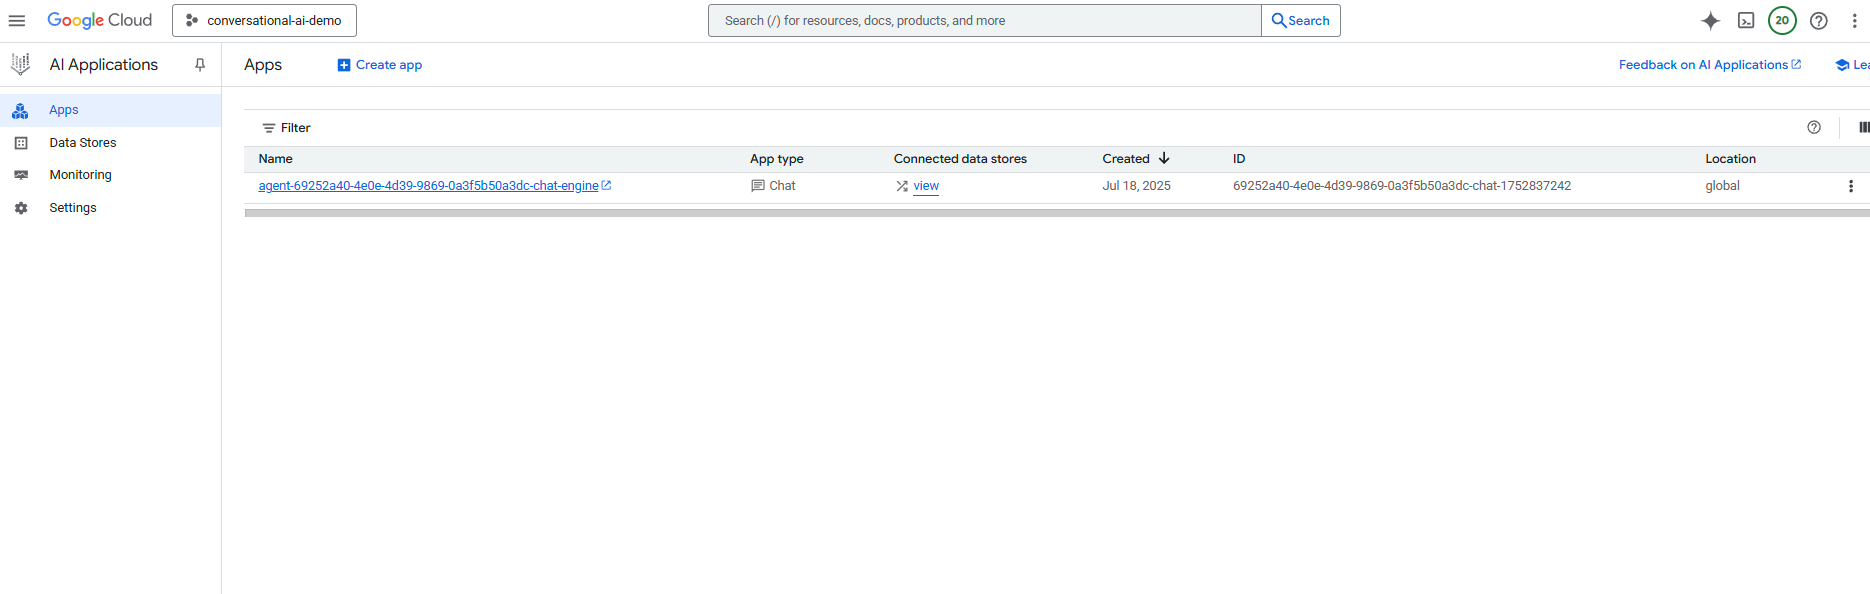

2.  **新しいアプリを作成**
    * 「**+ 新しいアプリ**」をクリックし、アプリの種類として「**Agentspace**」を選択します。
    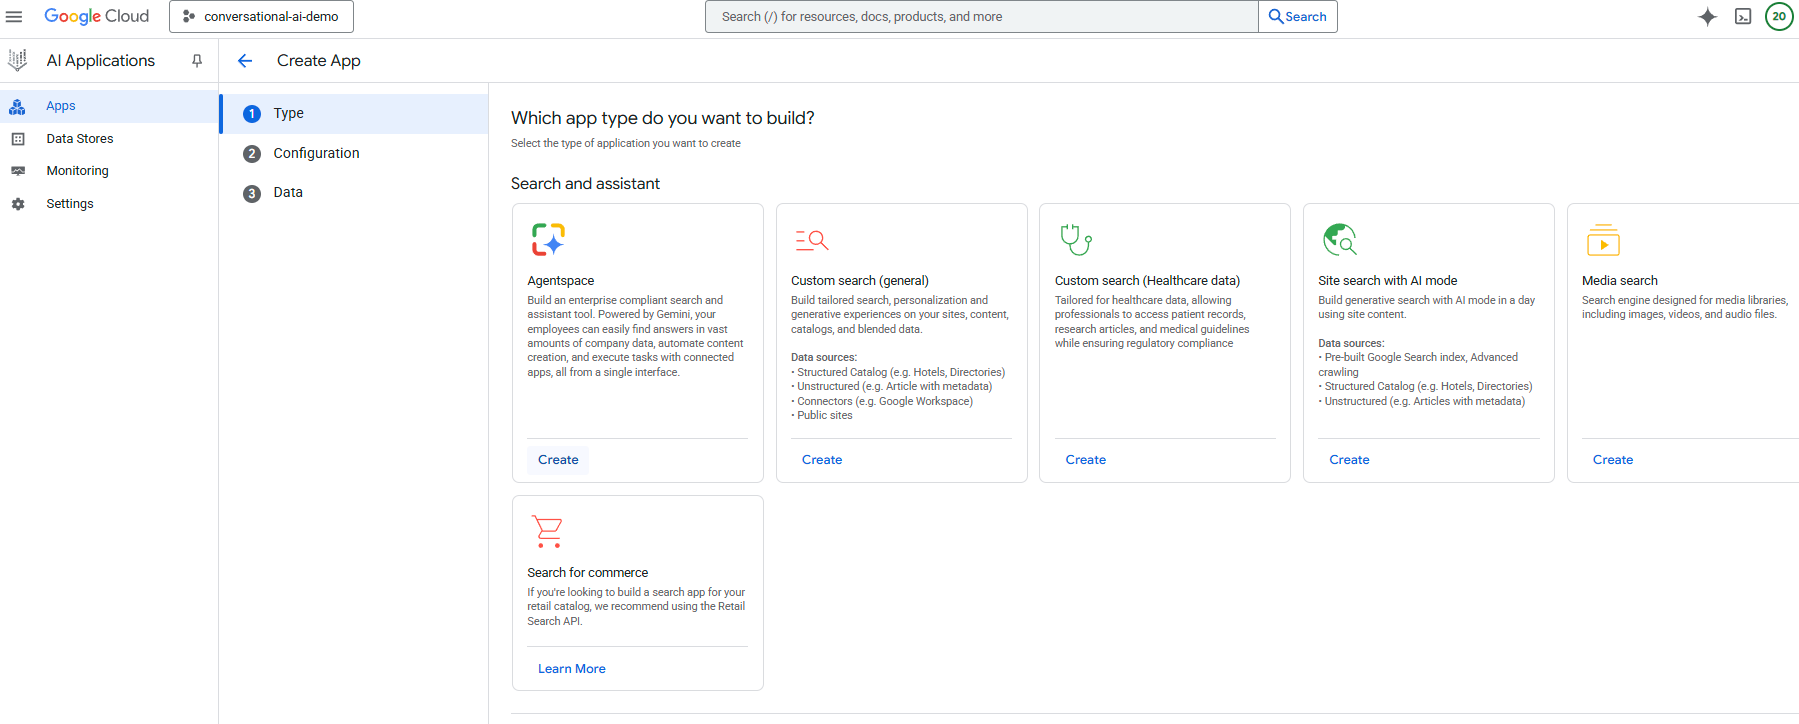

3.  **アプリ名を設定**
    * 「アプリ名」に `minitap-trends-app` と入力します。この名前は後ほど API を呼び出す際に**アプリ ID** として使用します。
    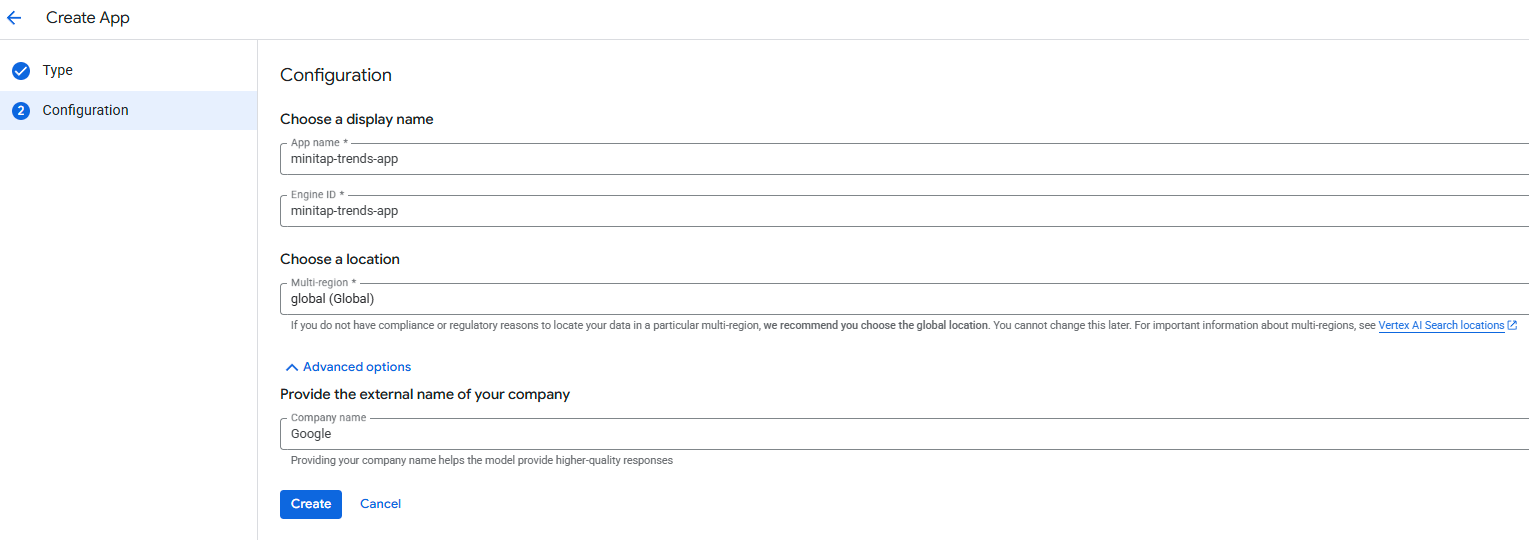

4.  **会社名を設定**
    * 「会社名」には任意の名前（例： `MiniTAP`）を入力します。

5.  **ロケーションを選択**
    * ロケーションとして「**グローバル（global）**」を選択します。

6.  **データストアの作成をスキップ**
    * 「データストアを作成」の画面が表示されますが、今回は外部ツールを利用するため、ここでは何も設定せずにアプリの作成を完了させてください。

7.  **アプリ ID を再確認**
    * 作成が完了すると、`minitap-trends-app` のページに移動します。この**アプリ ID** を次のステップで使用します。

#### 1. 変数を設定

まず、以下のコマンドを実行し、コマンド内で使用する変数を設定します。

ID はご自身の環境に合わせて書き換えてください。


In [29]:
import time
import json

def prepare_agentspace_registration():
    """Agentspace登録の準備"""

    registration_config = {
        "project_id": "data-agent-bq",
        "project_number": "258509337164",  # 実際のプロジェクト番号
        "location": "global",
        "reasoning_engine": remote_agent.resource_name,
        "display_name": "minitap-trends-app",
        "description": "Google Trends データを分析してマーケティングインサイトを提供",
        "tool_description": "1. まず `get_dataset_info_for_engine` や `get_table_info_for_engine` を使い、利用可能なデータの構造（スキーマなど）を把握します。 2. 把握したデータ構造を基に、ユーザーの質問に答えるための SQL クエリを頭の中で組み立てます。 3. 組み立てた SQL クエリを `execute_sql_for_engine` ツールを使って実行し、分析に必要な情報を取得します。",
        "agent_id": "minitap-trends-app",
        "as_app": f"minitap-trends-app"
    }

    print("🏢 Agentspace 登録設定:")
    print(json.dumps(registration_config, indent=2, ensure_ascii=False))

    return registration_config

# 登録設定の準備
agentspace_config = prepare_agentspace_registration()

# Agentspace 登録用の API コール例
if agentspace_config:
    print("\n📝 以下のコマンドをターミナルで実行してください。")
    print(f"""
    curl -X POST \\
      -H "Authorization: Bearer $(gcloud auth print-access-token)" \\
      -H "Content-Type: application/json" \\
      -H "x-goog-user-project: "{agentspace_config['project_id']}"" \\
      https://discoveryengine.googleapis.com/v1alpha/projects/{agentspace_config['project_id']}/locations/global/collections/default_collection/engines/{agentspace_config['as_app']}/assistants/default_assistant/agents \\
      -d '{{
          "displayName": "{agentspace_config['display_name']}",
          "description": "{agentspace_config['description']}",
          "adk_agent_definition": {{
            "tool_settings": {{
              "tool_description": "{agentspace_config['tool_description']}"
            }},
            "provisioned_reasoning_engine": {{
              "reasoning_engine": "{agentspace_config['reasoning_engine']}"
            }}
          }}
        }}'
    """)

🏢 Agentspace 登録設定:
{
  "project_id": "data-agent-bq",
  "project_number": "258509337164",
  "location": "global",
  "reasoning_engine": "projects/258509337164/locations/us-central1/reasoningEngines/796173961858646016",
  "display_name": "minitap-trends-app",
  "description": "Google Trends データを分析してマーケティングインサイトを提供",
  "tool_description": "1. まず `get_dataset_info_for_engine` や `get_table_info_for_engine` を使い、利用可能なデータの構造（スキーマなど）を把握します。 2. 把握したデータ構造を基に、ユーザーの質問に答えるための SQL クエリを頭の中で組み立てます。 3. 組み立てた SQL クエリを `execute_sql_for_engine` ツールを使って実行し、分析に必要な情報を取得します。",
  "agent_id": "minitap-trends-app",
  "as_app": "minitap-trends-app"
}

📝 以下のコマンドをターミナルで実行してください。

    curl -X POST \
      -H "Authorization: Bearer $(gcloud auth print-access-token)" \
      -H "Content-Type: application/json" \
      -H "x-goog-user-project: "data-agent-bq"" \
      https://discoveryengine.googleapis.com/v1alpha/projects/data-agent-bq/locations/global/collections/default_collection/engines/minitap-trends-app/assistan

#### ⚠️ メモ
事前に Allowlist に登録して貰う必要があります。


---

## 🧹 後片付け（オプション）

### リソースのクリーンアップ

In [7]:
def cleanup_resources():
    """リソースのクリーンアップ"""
    print("🧹 リソースのクリーンアップを開始...")

    # Agent Engineのエージェント削除
    try:
        if 'remote_agent' in locals():
            remote_agent.delete(force=True)
            print("✅ Agent Engine のエージェントを削除しました")
    except Exception as e:
        print(f"⚠️ Agent Engine 削除エラー: {e}")

    print("🏁 クリーンアップ完了")

# 注意: 以下のコメントアウトを外すとリソースが削除されます
# cleanup_resources()

print("🎊 お疲れさまでした！ MiniTAP ハンズオン完了です！")
print("💡 今後は自然言語でデータ分析ができるエージェントを活用してください！")

🎊 お疲れさまでした！ MiniTAP ハンズオン完了です！
💡 今後は自然言語でデータ分析ができるエージェントを活用してください！


---

## 🎯 **ハンズオンのハイライト**

この MiniTAP で体験できたこと：

### ✨ **自然言語でのデータ分析**
- **「過去 30 日の急上昇キーワードを分析して」** → エージェントが自動で SQL 生成・実行
- **「日本とイギリスのトレンドを比較して」** → 複数国データの比較分析を自動実行
- **「マーケティング戦略を提案して」** → ビジネス価値のある具体的提案を生成

### 🏗️ **スケーラブルなアーキテクチャ**
- **MCP Toolbox** による安全なデータアクセス
- **ADK Agent Native Toolkit** による簡単実装
- **Agent Engine** でのクラウドデプロイ
- **Agentspace** への登録

### 💼 **ビジネス活用可能**
- 自然言語での分析実行
- リアルタイムでの意思決定支援

**🚀 Happy Analytics 📊**